In [232]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime
from cpt_convert import loadCPT
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#For Map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker 
from matplotlib.patches import Rectangle
import matplotlib.colors as colors

#Stuff for Meteorological calculations 
import wrf
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, g_geoht, g_terrain, srhel, g_vorticity, g_dewpoint, tk, CoordPair, g_temp)

#Next thing: we need to know open up every file in the Dean Directory and loop through them!
import glob
import pandas as pd

In [233]:
#Color Table Stuff

def loadCPT(path):

    try:
        f = open(path)
    except:
        print ("File ", path, "not found")
        return None

    lines = f.readlines()

    f.close()

    x = np.array([])
    r = np.array([])
    g = np.array([])
    b = np.array([])

    colorModel = 'RGB'

    for l in lines:
        ls = l.split()
        if l[0] == '#':
            if ls[-1] == 'HSV':
                colorModel = 'HSV'
                continue
            else:
                continue
        if ls[0] == 'B' or ls[0] == 'F' or ls[0] == 'N':
            pass
        else:
            x=np.append(x,float(ls[0]))
            r=np.append(r,float(ls[1]))
            g=np.append(g,float(ls[2]))
            b=np.append(b,float(ls[3]))
            xtemp = float(ls[4])
            rtemp = float(ls[5])
            gtemp = float(ls[6])
            btemp = float(ls[7])

        x=np.append(x,xtemp)
        r=np.append(r,rtemp)
        g=np.append(g,gtemp)
        b=np.append(b,btemp)

    if colorModel == 'HSV':
        for i in range(r.shape[0]):
            rr, gg, bb = colorsys.hsv_to_rgb(r[i]/360.,g[i],b[i])
        r[i] = rr ; g[i] = gg ; b[i] = bb

    if colorModel == 'RGB':
        r = r/255.0
        g = g/255.0
        b = b/255.0

    xNorm = (x - x[0])/(x[-1] - x[0])

    red   = []
    blue  = []
    green = []

    for i in range(len(x)):
        red.append([xNorm[i],r[i],r[i]])
        green.append([xNorm[i],g[i],g[i]])
        blue.append([xNorm[i],b[i],b[i]])

    colorDict = {'red': red, 'green': green, 'blue': blue}

    return colorDict

In [234]:
#Function Below is for a storm following map projection. Credit: Dr. Sharanya Majumdar @The University of Miami
dataproj = ccrs.PlateCarree()

def create_map_background(tc_lon,tc_lat):
    
    crs = ccrs.PlateCarree()

    lat_min = 14
    lat_max = 19
    lon_min = 121
    lon_max = 133
     
    #Specify plot size
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, facecolor='gray', projection=crs)
    ax.coastlines(resolution='10m', alpha=0.9)
    
    #specify boundary extent from TC center. Current specifications give us a 10° x 10° projection
    gl = ax.gridlines(crs=crs, draw_labels=True, alpha=0.5)
    gl.top_labels = None
    gl.right_labels = None
    xgrid = np.arange(lon_min, lon_max + 1, 1.)
    ygrid = np.arange(lat_min, lat_max + 1, 1.)
    gl.xlocator = mticker.FixedLocator(xgrid.tolist())
    gl.ylocator = mticker.FixedLocator(ygrid.tolist())
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES)
    return fig, ax

In [235]:
#New Color Scale for IR Brightness
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

#Creating IR color Scale
def make_Ramp( ramp_colors ):
    from colour import Color
    from matplotlib.colors import LinearSegmentedColormap

    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

custom_ramp = make_Ramp( ["#00000a","#000014","#00001e","#000025","#00002a","#00002e","#000032","#000036","#00003a","#00003e",
                          "#000042","#000046","#00004a","#00004f","#000052","#010055","#010057","#020059","#02005c","#03005e",
                          "#040061","#040063","#050065","#060067","#070069","#08006b","#09006e","#0a0070","#0b0073","#0c0074",
                          "#0d0075","#0d0076","#0e0077","#100078","#120079","#13007b","#15007c","#17007d","#19007e","#1b0080",
                          "#1c0081","#1e0083","#200084","#220085","#240086","#260087","#280089","#2a0089","#2c008a","#2e008b",
                          "#30008c","#32008d","#34008e","#36008e","#38008f","#390090","#3b0091","#3c0092","#3e0093","#3f0093",
                          "#410094","#420095","#440095","#450096","#470096","#490096","#4a0096","#4c0097","#4e0097","#4f0097",
                          "#510097","#520098","#540098","#560098","#580099","#5a0099","#5c0099","#5d009a","#5f009a","#61009b",
                          "#63009b","#64009b","#66009b","#68009b","#6a009b","#6c009c","#6d009c","#6f009c","#70009c","#71009d",
                          "#73009d","#75009d","#77009d","#78009d","#7a009d","#7c009d","#7e009d","#7f009d","#81009d","#83009d",
                          "#84009d","#86009d","#87009d","#89009d","#8a009d","#8b009d","#8d009d","#8f009c","#91009c","#93009c",
                          "#95009c","#96009b","#98009b","#99009b","#9b009b","#9c009b","#9d009b","#9f009b","#a0009b","#a2009b",
                          "#a3009b","#a4009b","#a6009a","#a7009a","#a8009a","#a90099","#aa0099","#ab0099","#ad0099","#ae0198",
                          "#af0198","#b00198","#b00198","#b10197","#b20197","#b30196","#b40296","#b50295","#b60295","#b70395",
                          "#b80395","#b90495","#ba0495","#ba0494","#bb0593","#bc0593","#bd0593","#be0692","#bf0692","#bf0692",
                          "#c00791","#c00791","#c10890","#c10990","#c20a8f","#c30a8e","#c30b8e","#c40c8d","#c50c8c","#c60d8b",
                          "#c60e8a","#c70f89","#c81088","#c91187","#ca1286","#ca1385","#cb1385","#cb1484","#cc1582","#cd1681",
                          "#ce1780","#ce187e","#cf187c","#cf197b","#d01a79","#d11b78","#d11c76","#d21c75","#d21d74","#d31e72",
                          "#d32071","#d4216f","#d4226e","#d5236b","#d52469","#d62567","#d72665","#d82764","#d82862","#d92a60",
                          "#da2b5e","#da2c5c","#db2e5a","#db2f57","#dc2f54","#dd3051","#dd314e","#de324a","#de3347","#df3444",
                          "#df3541","#df363d","#e0373a","#e03837","#e03933","#e13a30","#e23b2d","#e23c2a","#e33d26","#e33e23",
                          "#e43f20","#e4411d","#e4421c","#e5431b","#e54419","#e54518","#e64616","#e74715","#e74814","#e74913",
                          "#e84a12","#e84c10","#e84c0f","#e94d0e","#e94d0d","#ea4e0c","#ea4f0c","#eb500b","#eb510a","#eb520a",
                          "#eb5309","#ec5409","#ec5608","#ec5708","#ec5808","#ed5907","#ed5a07","#ed5b06","#ee5c06","#ee5c05",
                          "#ee5d05","#ee5e05","#ef5f04","#ef6004","#ef6104","#ef6204","#f06303","#f06403","#f06503","#f16603",
                          "#f16603","#f16703","#f16803","#f16902","#f16a02","#f16b02","#f16b02","#f26c01","#f26d01","#f26e01",
                          "#f36f01","#f37001","#f37101","#f37201","#f47300","#f47400","#f47500","#f47600","#f47700","#f47800",
                          "#f47a00","#f57b00","#f57c00","#f57e00","#f57f00","#f68000","#f68100","#f68200","#f78300","#f78400",
                          "#f78500","#f78600","#f88700","#f88800","#f88800","#f88900","#f88a00","#f88b00","#f88c00","#f98d00",
                          "#f98d00","#f98e00","#f98f00","#f99000","#f99100","#f99200","#f99300","#fa9400","#fa9500","#fa9600",
                          "#fb9800","#fb9900","#fb9a00","#fb9c00","#fc9d00","#fc9f00","#fca000","#fca100","#fda200","#fda300",
                          "#fda400","#fda600","#fda700","#fda800","#fdaa00","#fdab00","#fdac00","#fdad00","#fdae00","#feaf00",
                          "#feb000","#feb100","#feb200","#feb300","#feb400","#feb500","#feb600","#feb800","#feb900","#feb900",
                          "#feba00","#febb00","#febc00","#febd00","#febe00","#fec000","#fec100","#fec200","#fec300","#fec400",
                          "#fec500","#fec600","#fec700","#fec800","#fec901","#feca01","#feca01","#fecb01","#fecc02","#fecd02",
                          "#fece03","#fecf04","#fecf04","#fed005","#fed106","#fed308","#fed409","#fed50a","#fed60a","#fed70b",
                          "#fed80c","#fed90d","#ffda0e","#ffda0e","#ffdb10","#ffdc12","#ffdc14","#ffdd16","#ffde19","#ffde1b",
                          "#ffdf1e","#ffe020","#ffe122","#ffe224","#ffe226","#ffe328","#ffe42b","#ffe42e","#ffe531","#ffe635",
                          "#ffe638","#ffe73c","#ffe83f","#ffe943","#ffea46","#ffeb49","#ffeb4d","#ffec50","#ffed54","#ffee57",
                          "#ffee5b","#ffee5f","#ffef63","#ffef67","#fff06a","#fff06e","#fff172","#fff177","#fff17b","#fff280",
                          "#fff285","#fff28a","#fff38e","#fff492","#fff496","#fff49a","#fff59e","#fff5a2","#fff5a6","#fff6aa",
                          "#fff6af","#fff7b3","#fff7b6","#fff8ba","#fff8bd","#fff8c1","#fff8c4","#fff9c7","#fff9ca","#fff9cd",
                          "#fffad1","#fffad4","#fffbd8","#fffcdb","#fffcdf","#fffde2","#fffde5","#fffde8","#fffeeb","#fffeee",
                          "#fffef1","#fffef4","#fffff6"]) 

top = custom_ramp
bottom = cm.get_cmap('Greys', 128)

newcolors = np.vstack((top(np.linspace(0,1,66)), 
                     bottom(np.linspace(0, 1, 33))))

newcmp = ListedColormap(newcolors, name = 'Cam_Cool_Color_Scale')

C:\Users\33017\AppData\Local\Temp\ipykernel_21592\3766475201.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('Greys', 128)


In [236]:
#the unadjusted domain has 9 more files than the adjusted run due to our lovely HPC
Parent_wrfout_unadjusted_d02 = Dataset(r'D:\wrfout_d02_2022-09-23_18_00_00')


In [237]:
#first, we are going to calculate the pressure center for our center following plots

tc_lon = []                                             #Empty List for TC center longitude
tc_lat = []                                             #Empty List for TC center latitude


#Start looking for pressure minimum in WRF out files

wrf_out_data = Parent_wrfout_unadjusted_d02

    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
P_pertubation = getvar(wrf_out_data, "AFWA_MSLP", timeidx=35)
surface_P_pertubation = P_pertubation
    
    #Now, to find the location of the lowest surface pressure pertubation
minpressure = np.min(surface_P_pertubation[:,:])
minp = minpressure.values

    #Now we know what the lowest pressure is, we have to find the index value for where it occurs
da = surface_P_pertubation
p_index = np.argwhere(da.where(da == minp,0).values)
s_n = p_index[0][0]
w_e = p_index[0][1]

    #Append lat and longitude centers into a list for plotting
lon = wrf_out_data['XLONG'][0,s_n,w_e]
tc_lon.append(lon)
lat = wrf_out_data['XLAT'][0,s_n,w_e]
tc_lat.append(lat)

In [238]:
X_Y_Sounding_Center = []

#now we need to get the x_y points of each lat longitude coordinate

file = Parent_wrfout_unadjusted_d02
wrfin = file
x_ycenter = wrf.ll_to_xy(wrfin, tc_lat, tc_lon)
X_Y_Sounding_Center.append(x_ycenter)

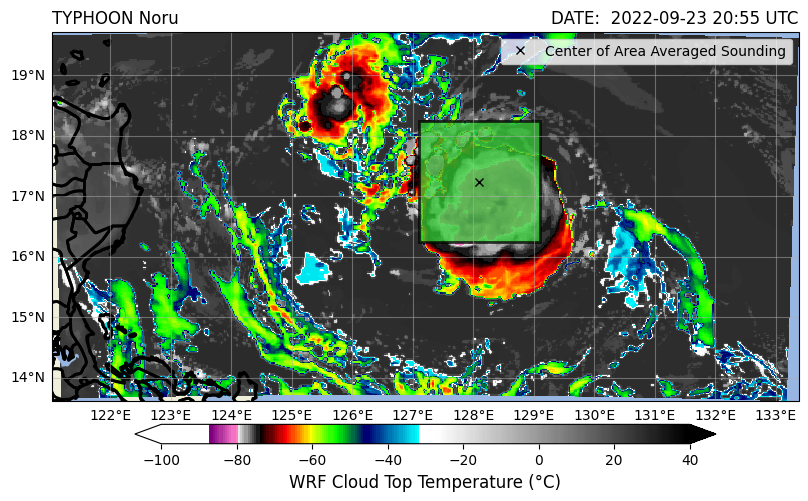

In [244]:
#constant Needed for Calcualtions
sigma = 5.67 * 10**-8                           #Stefon-Boltzman Constant

#compare sounding location to IR brightness to make sure it is in the correct location
wrf_out_data = wrfin         #Open WRF_Out Data (I sorted glob glob my whole directory)
wrf_out_ctt = getvar(ncfile, "ctt", timeidx=35)

sigma = 0.5  # You can adjust this value for more or less smoothing
IR_smoothed = gaussian_filter(wrf_out_ctt, sigma=sigma)
    
ncfile = file
Time = wrf.extract_times(ncfile, timeidx=35, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
timestr = (str(Time))
    
titletime=(timestr[0:10]+' '+timestr[11:16])
filetime=(timestr[0:10]+'_'+timestr[11:13])

colortable = loadCPT('C:/Users/33017/Desktop/WRF Scripts/IR4AVHRR6.cpt')
ct = LinearSegmentedColormap('cpt', colortable)

    #Plot OLR Data
fig, ax = create_map_background(tc_lon,tc_lat) #We are only looking at 11 indices, and our list goes from 0-11, not 24 and up

plot = ax.pcolormesh(wrf_out_data['XLONG'][0,:,:], wrf_out_data['XLAT'][0,:,:], IR_smoothed, cmap=ct, norm=plt.Normalize(-100, 40))

cbar = plt.colorbar(plot, orientation = 'horizontal', pad = .05, shrink = .75, aspect = 30, extend = 'both')
cbar.ax.set_xlabel('WRF Cloud Top Temperature (°C)', fontsize = 12)
 
    #For Sounding Location
lon_i = tc_lon[0]
lat_i = tc_lat[0]

plt.plot(lon_i, lat_i, "x", color = 'black', label = "Center of Area Averaged Sounding")

# Calculate the center of the area-averaged sounding
center_lon = tc_lon[0]
center_lat = tc_lat[0]

# Calculate the new bottom left point based on the center of the sounding
new_bl_lon = center_lon - 1
new_bl_lat = center_lat - 1

# Calculate the top right point based on the new bottom left point
new_tr_lon = center_lon + 1
new_tr_lat = center_lat + 1

# Calculate the width and height of the square
width = new_tr_lon - new_bl_lon
height = new_tr_lat - new_bl_lat

# Add the square to the plot using the new bottom left point
ax.add_patch(Rectangle((new_bl_lon, new_bl_lat), width, height, edgecolor='black', facecolor='limegreen', fill=True, alpha=0.75, lw=2))

    #Add Coastlines
ax.coastlines('50m', linewidth=2)
ax.add_feature(cfeature.STATES, linewidth=2)
ax.add_feature(cfeature.BORDERS, linewidth=2)

plt.title(f'DATE: '+' '+titletime+' UTC', loc = 'right', fontsize = 12)
plt.title('TYPHOON Noru', loc = 'left', fontsize = 12)
plt.legend()

(44, 5, 5)
Coordinates:
    XLONG    (south_north, west_east) float32 121.4 121.5 121.5 ... 121.5 121.5
    XLAT     (south_north, west_east) float32 16.18 16.18 16.18 ... 16.26 16.26
    XTIME    float32 715.0
    Time     datetime64[ns] 2022-09-24T02:55:00


C:\Users\33017\AppData\Local\Temp\ipykernel_21592\2515910134.py:147: UserWarning: More than one time coordinate present for variable  "pressure".
  KIndex = mpcalc.k_index(p_avg, T_avg, Td_avg)


MUCAPE: 334.1686649516043 joule / kilogram
MLCAPE: 0 joule / kilogram
SBCAPE: 334.1686649516043 joule / kilogram
KIndex: 25.676617986782613 degree_Celsius


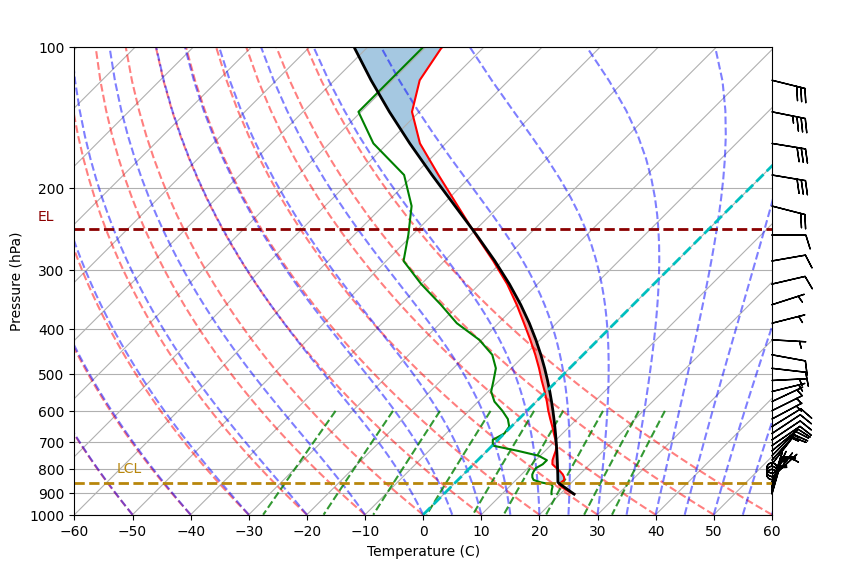

In [264]:
#Now that we have specified that the location of interest is indeed where we want it, 
#we can take an area average sounding!
from metpy.plots import Hodograph

sigma = 5.67 * 10**-8                                                    #Stefon-Boltzman Constant
    
wrfin = file
    
wrf_out_data = wrfin          #Open WRF_Out Data (I sorted glob glob my whole directory)
wrf_out_ctt = getvar(ncfile, "ctt", timeidx=35)
    
    #Get pertinent values necessary for skew-T
p1 = wrf.getvar(wrfin,"pressure",timeidx=35)               #Pressure
T1 = wrf.getvar(wrfin,"tc",timeidx=35)                     #Temperature
Td1 = wrf.getvar(wrfin,"td",timeidx=35)                    #Dewpoint
u = wrf.getvar(wrfin,"ua",timeidx=35)                     #Zonal Winds
v = wrf.getvar(wrfin,"va",timeidx=35)                     #Meridional Winds
u1 = u * 1.944
v1 = v * 1.944
pot1 = wrf.getvar(wrfin,"th",timeidx=35)                   #potential Temperature
height1 = wrf.getvar(wrfin,"height_agl",timeidx=35)        #Height above ground level for mass point
height = height = g_geoht.get_height(wrfin, timeidx=35, units='m')
terrain = g_terrain.get_terrain(ncfile, timeidx=35, units='m')

THREESRH = srhel(u, v, height, terrain, top=3000.0)
    
    #Now that we are done with our textfile, we want to make a nice skew_T:
p_area =  (p1[:,int(new_bl_lon):int(new_tr_lon),
                 int(new_bl_lat):int(new_tr_lat)]   * units.hPa)        #Average Pressure in Hpa 
    
T_area =  (T1[:,int(new_bl_lon):int(new_tr_lon),
                 int(new_bl_lat):int(new_tr_lat)]   * units.degC)       #Average Temperature in Degrees Celsius
  
Td_area = (Td1[:,int(new_bl_lon):int(new_tr_lon),
                 int(new_bl_lat):int(new_tr_lat)]  * units.degC)       #Average Dewpoint Temperature in Degrees Celsius
   
u_area =  (u1[:,int(new_bl_lon):int(new_tr_lon),
                 int(new_bl_lat):int(new_tr_lat)]   * units('kt'))     #Average Zonal Winds in m/s                  

v_area =  (v1[:,int(new_bl_lon):int(new_tr_lon),
                 int(new_bl_lat):int(new_tr_lat)]   * units('kt'))     #Average Meridional winds in m/s

height_area =  (height[:,int(new_bl_lon):int(new_tr_lon),
                 int(new_bl_lat):int(new_tr_lat)]   * units('m'))     #Average Geopotential Height in meters

height1_area =  (height1[:,int(new_bl_lon):int(new_tr_lon),
                 int(new_bl_lat):int(new_tr_lat)]   * units('m'))     #Average Height AGL in meters

SRH_area = THREESRH[int(new_bl_lon):int(new_tr_lon), int(new_bl_lat):int(new_tr_lat)]
SRH_avg = SRH_area.mean()

print(p_area.shape)
print(p_area.coords)
    
    #to take the area average sounding, we need to average (mean) about the S_N and W_E arrays
p_avg_we = p_area.mean(dim = 'south_north')      #Average out area sounding across the S_n array
p_avg    = p_avg_we.mean(dim = 'west_east')      #Average our area + S_N average by the W_E so we have a 1d array with pressure levels and values

    #Same for Tempearture
T_avg_we = T_area.mean(dim = 'south_north')
T_avg    = T_avg_we.mean(dim = 'west_east')

    #Same For Dewpopint
Td_avg_we = Td_area.mean(dim = 'south_north')
Td_avg    = Td_avg_we.mean(dim = 'west_east')

    #Same for zonal wind
u_avg_we = u_area.mean(dim = 'south_north')
u_avg    = u_avg_we.mean(dim = 'west_east')

    #Same for meridional wind
v_avg_we = v_area.mean(dim = 'south_north')
v_avg    = v_avg_we.mean(dim = 'west_east')

    #Same for Geopotential Height
height_avg_we = height_area.mean(dim = 'south_north')
height_avg    = height_avg_we.mean(dim = 'west_east')

    #Same for Height AGL
height1_avg_we = height1_area.mean(dim = 'south_north')
height1_avg    = height1_avg_we.mean(dim = 'west_east')
    
    
ncfile = wrfin
Time = wrf.extract_times(ncfile, timeidx=35, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
timestr = (str(Time))
    
titletime=(timestr[0:10]+' '+timestr[11:16])
filetime=(timestr[0:10]+'_'+timestr[11:13])

fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.
skew.plot(p_avg[:], T_avg[:], 'r')
skew.plot(p_avg[:], Td_avg[:], 'g')
skew.plot_barbs(p_avg[:-5].values, u_avg[:-5], v_avg[:-5])
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-60, 60)

# Set some better labels than the default
skew.ax.set_xlabel(f'Temperature (C)')
skew.ax.set_ylabel(f'Pressure (hPa)')

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
lcl_pressure, lcl_temperature = mpcalc.lcl(p_avg[0], T_avg[0], Td_avg[0])
skew.ax.axhline(lcl_pressure, color='#B8860B', linestyle='--', linewidth=2)

text_offset = 40  # You can adjust this value to control the vertical position of the text
skew.ax.text(-60, lcl_pressure.magnitude - text_offset, 'LCL', color='#B8860B')

#EL
el_pressure, el_temperature = mpcalc.el(p_avg, T_avg, Td_avg)
skew.ax.axhline(el_pressure, color='darkred', linestyle='--', linewidth=2)

text_offset = 10  # You can adjust this value to control the vertical position of the text
skew.ax.text(-117, el_pressure.magnitude - text_offset, 'EL', color='darkred')


# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p_avg, T_avg[0], Td_avg[0])
prof = prof.values - 273.15
skew.plot(p_avg, prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p_avg.values, T_avg.values, prof) 
skew.shade_cape(p_avg.values, T_avg.values, prof)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

MUCAPE, MUCIN = mpcalc.most_unstable_cape_cin(p_avg, T_avg, Td_avg)
mixed_parcel_profile = mpcalc.mixed_parcel(p_avg, T_avg, Td_avg)
MLCAPE, MLCIN = mpcalc.mixed_layer_cape_cin(p_avg, T_avg, Td_avg)
SBCAPE, SBCIN = mpcalc.surface_based_cape_cin(p_avg, T_avg, Td_avg)
KIndex = mpcalc.k_index(p_avg, T_avg, Td_avg)
print("MUCAPE:", MUCAPE.item())
print("MLCAPE:", MLCAPE.item())
print("SBCAPE:", SBCAPE.item())
print("KIndex:", KIndex.item())


# Show the plot
plt.show()
